In [1]:
import numpy as np
import pandas as pd
import easydatascience as eds

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import waterfall_chart

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
import joblib

plt.rcParams.update({'figure.figsize':(8, 5), 'figure.dpi':100})

data = pd.read_csv('data.csv')

X_train, X_test, y_train, y_test = train_test_split(data.drop('Blue_Won', axis=1), 
                                                    data['Blue_Won'], test_size=0.1)

## EDA

### Baseline

In [2]:
def kfold_test(df, y, model, iters=1, kfolds=10):
    # K-fold CV over n iterations. Returns a list of lists
    # containing average accuracies and their stds
    kf = KFold(kfolds, shuffle=True)
    out = []

    for iter in range(iters):
        accuracies = []
        # k1 = k-1
        for k1_fold, k_fold in kf.split(df):
            model.fit(df.iloc[k1_fold], y.iloc[k1_fold])
        
            accuracies.append(accuracy_score(y.iloc[k_fold],
                              model.predict(df.iloc[k_fold])))
            
        out.append([np.mean(accuracies).round(3), np.std(accuracies).round(3)])
    
    return out

In [3]:
og_train, og_test = X_train.iloc[:, 1:15], X_test.iloc[:, 1:15]

xgbc = XGBClassifier()

og_scores = kfold_test(og_train, y_train, xgbc, iters=3, kfolds=5)

print('Accuracies of a simple model:\n')
for i, v in enumerate(og_scores):
    print('Iteration '+str(i+1)+':\nMean: '+str(v[0])+' Std: '+str(v[1])+'\n')

Accuracies of a simple model:

Iteration 1:
Mean: 0.986 Std: 0.003

Iteration 2:
Mean: 0.985 Std: 0.002

Iteration 3:
Mean: 0.986 Std: 0.003



In [4]:
# Fitting the model, printing feature importances and then removing
# the most influential feature. The process is repeated.

def minus_one(df, y, model, iters):
    curr_data = df.copy()

    for _ in range(iters):
        model.fit(curr_data, y);

        for ftr, imprt in zip(curr_data.columns, model.feature_importances_):
            print(ftr, imprt.round(3))
        
        # Drop the most influential feature
        curr_data = curr_data.drop(curr_data.columns[model.feature_importances_.argmax()], axis=1)
        print(21*'-')
    
minus_one(og_train, y_train, XGBClassifier(), og_train.shape[1]-1)

Blue_KillsTower 0.088
Blue_KillsInhib 0.053
Blue_KillsBaron 0.006
Blue_KillsDragon 0.006
Purp_KillsTower 0.091
Purp_KillsInhib 0.705
Purp_KillsBaron 0.009
Purp_KillsDragon 0.007
Blue_Kills 0.004
Blue_Assists 0.009
Blue_Gold 0.004
Purp_Kills 0.003
Purp_Assists 0.01
Purp_Gold 0.005
---------------------
Blue_KillsTower 0.062
Blue_KillsInhib 0.527
Blue_KillsBaron 0.008
Blue_KillsDragon 0.008
Purp_KillsTower 0.323
Purp_KillsBaron 0.013
Purp_KillsDragon 0.009
Blue_Kills 0.004
Blue_Assists 0.012
Blue_Gold 0.007
Purp_Kills 0.005
Purp_Assists 0.016
Purp_Gold 0.006
---------------------
Blue_KillsTower 0.152
Blue_KillsBaron 0.012
Blue_KillsDragon 0.008
Purp_KillsTower 0.717
Purp_KillsBaron 0.018
Purp_KillsDragon 0.014
Blue_Kills 0.007
Blue_Assists 0.021
Blue_Gold 0.009
Purp_Kills 0.005
Purp_Assists 0.026
Purp_Gold 0.009
---------------------
Blue_KillsTower 0.736
Blue_KillsBaron 0.009
Blue_KillsDragon 0.017
Purp_KillsBaron 0.069
Purp_KillsDragon 0.015
Blue_Kills 0.01
Blue_Assists 0.026
Blue_Gol

### Prediction influencers and the "Dragons" features

In [5]:
dragon_X, dragon_y = og_train.drop(['Blue_KillsDragon', 'Purp_KillsDragon'], axis=1), og_train['Blue_KillsDragon']

xgbr = XGBRegressor()

xgbr.fit(dragon_X, dragon_y)
minus_one(dragon_X, dragon_y, XGBRegressor(), 5)

Blue_KillsTower 0.47
Blue_KillsInhib 0.028
Blue_KillsBaron 0.027
Purp_KillsTower 0.075
Purp_KillsInhib 0.039
Purp_KillsBaron 0.035
Blue_Kills 0.042
Blue_Assists 0.04
Blue_Gold 0.085
Purp_Kills 0.066
Purp_Assists 0.042
Purp_Gold 0.05
---------------------
Blue_KillsInhib 0.578
Blue_KillsBaron 0.018
Purp_KillsTower 0.052
Purp_KillsInhib 0.047
Purp_KillsBaron 0.024
Blue_Kills 0.042
Blue_Assists 0.028
Blue_Gold 0.076
Purp_Kills 0.058
Purp_Assists 0.034
Purp_Gold 0.042
---------------------
Blue_KillsBaron 0.019
Purp_KillsTower 0.417
Purp_KillsInhib 0.044
Purp_KillsBaron 0.038
Blue_Kills 0.059
Blue_Assists 0.044
Blue_Gold 0.176
Purp_Kills 0.091
Purp_Assists 0.052
Purp_Gold 0.061
---------------------
Blue_KillsBaron 0.019
Purp_KillsInhib 0.562
Purp_KillsBaron 0.024
Blue_Kills 0.054
Blue_Assists 0.034
Blue_Gold 0.14
Purp_Kills 0.076
Purp_Assists 0.039
Purp_Gold 0.053
---------------------
Blue_KillsBaron 0.027
Purp_KillsBaron 0.032
Blue_Kills 0.158
Blue_Assists 0.053
Blue_Gold 0.287
Purp_Kil

Predicting the # of dragons tests:

RMSE: 1.01

Confusion matrix of the rounded predictions:


,0 Drakes,1 Drakes,2 Drakes,3 Drakes,4 Drakes,5 Drakes
0 Drakes,11,107,28,3,0,0
1 Drakes,16,131,75,32,2,0
2 Drakes,1,75,86,112,13,0
3 Drakes,0,24,68,114,17,2
4 Drakes,0,3,32,130,34,0
5 Drakes,0,0,0,10,11,0


Text(0, 0.5, 'Predicted values')

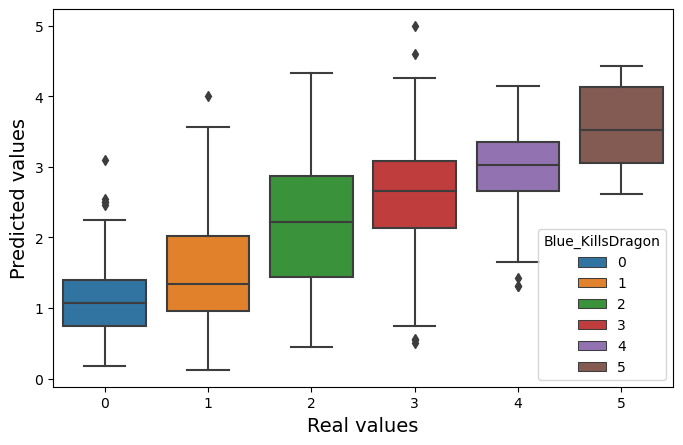

In [6]:
dragon_X_test, dragon_y_test = og_test.drop(['Blue_KillsDragon', 'Purp_KillsDragon'], axis=1), og_test['Blue_KillsDragon']
preds = xgbr.predict(dragon_X_test)

rmse = np.sqrt(mean_squared_error(dragon_y_test, preds))
print('Predicting the # of dragons tests:\n\nRMSE:', round(rmse, 3))

# Rounding the predictions and making a confusion matrix
col_names = [str(i) + ' Drakes' for i in range(6)]
print('\nConfusion matrix of the rounded predictions:')
display(pd.DataFrame(confusion_matrix(dragon_y_test, np.round(preds)), index=col_names, columns=col_names))

print('\n\n')

fig, ax = plt.subplots()
sns.boxplot(x=dragon_y_test, y=preds, hue=dragon_y_test, dodge=False)
ax.set_xlabel('Real values', fontsize=14)
ax.set_ylabel('Predicted values', fontsize=14)

### More simple model evaluation

In [7]:
# Logistic regression for influencers
# Bad model because of the between feature colinearity but interpretable
scaler = StandardScaler()

scaler.fit(og_train)
og_scaled_train, og_scaled_test = scaler.transform(og_train), scaler.transform(og_test)

cv_lr = kfold_test(pd.DataFrame(og_train), y_train, LogisticRegression(max_iter=1000))[0]
cv_scaled_lr = kfold_test(pd.DataFrame(og_scaled_train), y_train, LogisticRegression())[0]

print('Means and standard deviations of single 10-fold cv-s:\nUnscaled:', cv_lr, '\nScaled:', cv_scaled_lr)

Means and standard deviations of single 10-fold cv-s:
Unscaled: [0.984, 0.006] 
Scaled: [0.985, 0.003]


<strong>&emsp;Note: The Logistic Regression model does not converge at all at default "max_iter = 100" (ConvergenceWarining) if the data isn't scaled.<strong>

In [8]:
coefs = pd.concat([pd.Series(i) for i in [xgbc.feature_importances_, LogisticRegression().fit(og_scaled_train, y_train).coef_[0],
                                          og_train.corrwith(y_train).values]], axis=1)
coefs.columns, coefs.index = ['XGBC Ft.Imp.', 'Log.Reg.Coef.', 'Target corr.'], og_train.columns
coefs = coefs.round(3)
coefs

,XGBC Ft.Imp.,Log.Reg.Coef.,Target corr.
Blue_KillsTower,0.073,1.226,0.814
Blue_KillsInhib,0.067,0.974,0.703
Blue_KillsBaron,0.007,0.020,0.513
Blue_KillsDragon,0.007,0.477,0.578
Purp_KillsTower,0.134,-1.536,-0.821
Purp_KillsInhib,0.653,-0.617,-0.711
Purp_KillsBaron,0.009,0.213,-0.547
Purp_KillsDragon,0.009,0.135,-0.588
Blue_Kills,0.005,-0.577,0.575
Blue_Assists,0.011,1.288,0.539


&emsp;<u>Columns of interest:</u><br>
 - <b>Purp_KillsInhib</b> - It seems that XGBoost does a poor job of generalizing, and in this sample (the feature with the greatest feature importance will probably change as I rerun the cells multiple times) it is that Putp_KillsInhib that is heavility weighted. This could be adressed with model tuning but XGBoost with default hyperparameters doesn't seem like the best option right now.
 - <b>Blue_KillsBaron</b> and <b>Purp_KillsBaron</b> - The multicollinearity is taking its toll here. It messes up the features so even though the correlation is positive, the weight is negative because these features are influenced by other features.
 - <b>Blue_Kills</b> and <b>Purp_Kills</b> - Same story as with the baron features.

### Diff features

In [9]:
blue = pd.concat([og_train.iloc[:, :4], og_train.iloc[:, 8:11]], axis=1)
purp = pd.concat([og_train.iloc[:, 4:8], og_train.iloc[:, 11:14]], axis=1)

for df in [blue, purp]:
    df.columns = ['Diff_Kills'+i for i in ['Tower', 'Inhib', 'Baron', 'Dragon', '']] + ['Diff_'+i for i in ['Assists', 'Gold']]
    
diff_data = blue - purp
xgbc.fit(diff_data, y_train)

diff_scores = kfold_test(diff_data, y_train, xgbc, iters=3, kfolds=5)
print('Accuracies of the diff model:\n')
for i, v in enumerate(diff_scores):
    print('Iteration '+str(i+1)+':\nMean: '+str(v[0])+' Std: '+str(v[1])+'\n')

Accuracies of the diff model:

Iteration 1:
Mean: 0.984 Std: 0.004

Iteration 2:
Mean: 0.984 Std: 0.002

Iteration 3:
Mean: 0.985 Std: 0.001



In [10]:
# Test diff data
blue = pd.concat([og_test.iloc[:, :4], og_test.iloc[:, 8:11]], axis=1)
purp = pd.concat([og_test.iloc[:, 4:8], og_test.iloc[:, 11:14]], axis=1)

for df in [blue, purp]:
    df.columns = ['Diff_Kills'+i for i in ['Tower', 'Inhib', 'Baron', 'Dragon', '']] + ['Diff_'+i for i in ['Assists', 'Gold']]

diff_test = blue - purp

In [11]:
print('Between-feature correnaltions in the difference data:')
eds.print_abv_ft_corr(diff_data)

Between-feature correnaltions in the difference data:

---------------------
 Diff_KillsTower:
---------------------

Diff_KillsInhib 0.9065
Diff_KillsBaron 0.5987
Diff_KillsDragon 0.631
Diff_Kills 0.8209
Diff_Assists 0.6502
Diff_Gold 0.9204

---------------------
 Diff_KillsInhib:
---------------------

Diff_KillsTower 0.9065
Diff_KillsBaron 0.579
Diff_KillsDragon 0.5676
Diff_Kills 0.7255
Diff_Assists 0.5904
Diff_Gold 0.8072

---------------------
 Diff_KillsBaron:
---------------------

Diff_KillsTower 0.5987
Diff_KillsInhib 0.579
Diff_KillsDragon 0.4052
Diff_Kills 0.5467
Diff_Assists 0.5025
Diff_Gold 0.67

---------------------
 Diff_KillsDragon:
---------------------

Diff_KillsTower 0.631
Diff_KillsInhib 0.5676
Diff_KillsBaron 0.4052
Diff_Kills 0.6312
Diff_Assists 0.492
Diff_Gold 0.6534

---------------------
 Diff_Kills:
---------------------

Diff_KillsTower 0.8209
Diff_KillsInhib 0.7255
Diff_KillsBaron 0.5467
Diff_KillsDragon 0.6312
Diff_Assists 0.849
Diff_Gold 0.9166

--------

In [12]:
coefs = pd.concat([pd.Series(i) for i in [xgbc.feature_importances_, LogisticRegression().fit(StandardScaler().fit_transform(diff_data), y_train).coef_[0],
                                          diff_data.corrwith(y_train).values]], axis=1)
coefs.columns, coefs.index = ['XGBC Ft.Imp.', 'Log.Reg.Coef.', 'Target corr.'], diff_data.columns
coefs = coefs.round(3)

print('Features in the difference data:')
display(coefs)

Features in the difference data:


,XGBC Ft.Imp.,Log.Reg.Coef.,Target corr.
Diff_KillsTower,0.035,2.331,0.874
Diff_KillsInhib,0.084,1.475,0.809
Diff_KillsBaron,0.011,-0.239,0.631
Diff_KillsDragon,0.013,0.300,0.618
Diff_Kills,0.012,-1.171,0.829
Diff_Assists,0.020,1.958,0.756
Diff_Gold,0.825,5.294,0.900


### Diff Gold feature prediction

In [13]:
y_diff_gold = diff_data['Diff_Gold']
X_diff_gold = diff_data.drop('Diff_Gold', axis=1)

y_diff_gold_test = diff_test['Diff_Gold']
X_diff_gold_test = diff_test.drop('Diff_Gold', axis=1)

scaler.fit(X_diff_gold)

# Normalized "y"
#from sklearn.preprocessing import PowerTransformer

#pt = PowerTransformer()

# Linear Regression
lr_gold = LinearRegression()
lr_gold.fit(scaler.transform(X_diff_gold), y_diff_gold)

preds = lr_gold.predict(scaler.transform(X_diff_gold_test))

print('RMSE of the Gold_Diff in the test set:', np.sqrt(mean_squared_error(y_diff_gold_test, preds)))

# XGB Regressor
xgb_gold = XGBRegressor()

xgb_gold.fit(X_diff_gold, y_diff_gold)

xgb_preds = xgb_gold.predict(X_diff_gold_test)
print('RMSE of the Gold_Diff in the test set:', np.sqrt(mean_squared_error(y_diff_gold_test, xgb_preds)))

RMSE of the Gold_Diff in the test set: 2221.869753341692
RMSE of the Gold_Diff in the test set: 2278.6152329604633


Distribution of the Gold Difference in the predictions:


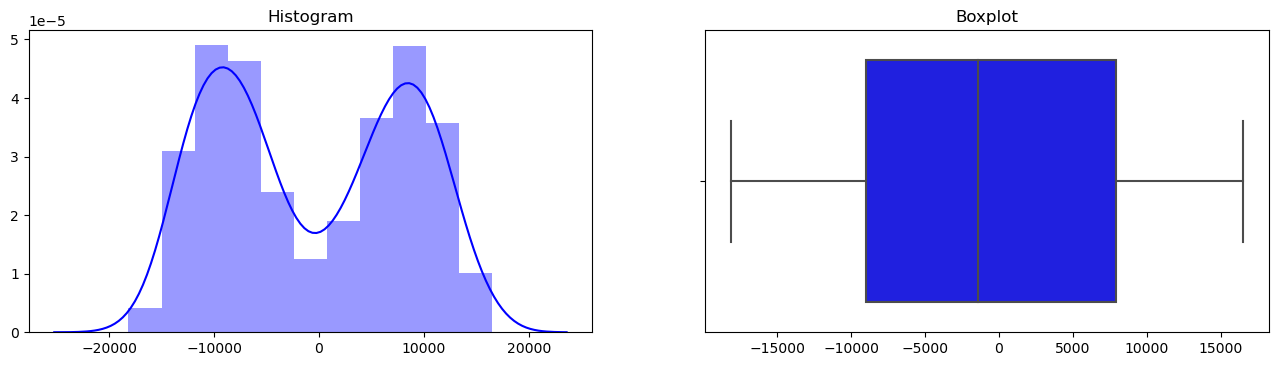


Skew:  0.0554
Mean:  -599.8711
Standard Deviation:  9093.6718


Distribution of the Gold Difference in the train set:


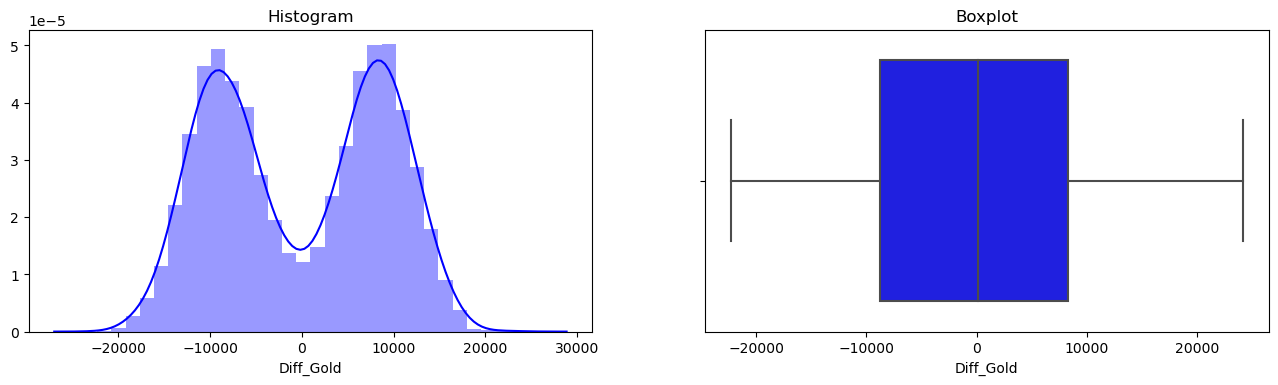


Skew:  -0.0184
Mean:  -157.5943
Standard Deviation:  9329.0754


In [14]:
print('Distribution of the Gold Difference in the predictions:')
eds.plot_spread(pd.Series(preds.flatten()))

print('\n\nDistribution of the Gold Difference in the train set:')
eds.plot_spread(y_diff_gold)

In [15]:
print('Sample Predictions:')
pd.concat([X_diff_gold_test, pd.Series(preds, index=X_diff_gold_test.index)], axis=1).rename(columns={0: 'Pred_Diff_Gold'}).sample(5)

Sample Predictions:


,Diff_KillsTower,Diff_KillsInhib,Diff_KillsBaron,Diff_KillsDragon,Diff_Kills,Diff_Assists,Pred_Diff_Gold
10518,-4,-1,-1,0,-14.0,-27.0,-8590.185552
5600,2,1,1,-1,16.0,46.0,7379.138336
885,-3,-1,-1,-4,-5.0,-34.0,-5828.509534
7958,-9,-3,-1,-3,-12.0,-12.0,-10973.217208
580,-7,-2,-1,-2,-16.0,-23.0,-11154.008638


How prediction varies based on each feature

Feature vecotr used in the plot:


,Diff_KillsTower,Diff_KillsInhib,Diff_KillsBaron,Diff_KillsDragon,Diff_Kills,Diff_Assists
9749,5,2,0,4,5.0,28.0


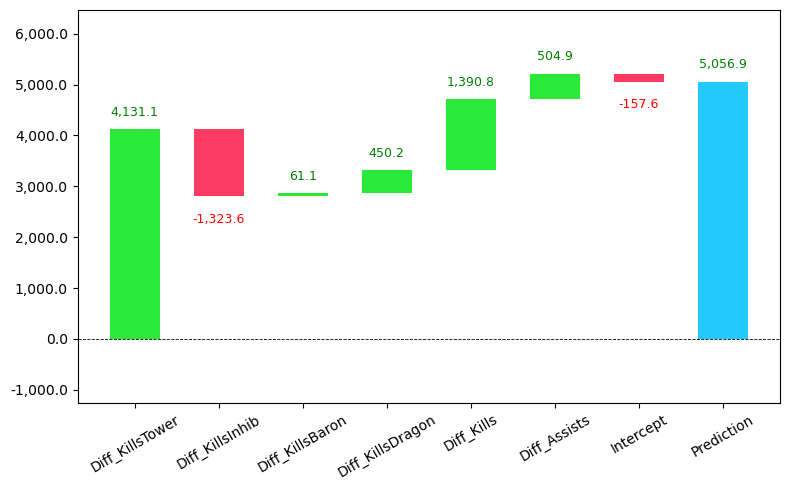

In [16]:
# Plotting Linear Regression influencers
values = (scaler.transform(X_diff_gold_test.iloc[:1]) * lr_gold.coef_).tolist()[0] + [lr_gold.intercept_]

print('How prediction varies based on each feature\n\nFeature vecotr used in the plot:')
display(X_diff_gold_test.iloc[:1])

waterfall_chart.plot(X_diff_gold.columns.tolist()+['Intercept'], values, net_label='Prediction');

In [17]:
gold_coefs = pd.concat([pd.Series(i) for i in [xgb_gold.feature_importances_, lr_gold.coef_,
                                          X_diff_gold.corrwith(y_diff_gold).values]], axis=1)
gold_coefs.columns, gold_coefs.index = ['XGBC Ft.Imp.', 'Lin.Reg.Coef.', 'Target corr.'], X_diff_gold.columns
gold_coefs = gold_coefs.round(3)

print('Features in the difference data:')
display(gold_coefs)

Features in the difference data:


,XGBC Ft.Imp.,Lin.Reg.Coef.,Target corr.
Diff_KillsTower,0.784,5376.333,0.920
Diff_KillsInhib,0.009,-1304.867,0.807
Diff_KillsBaron,0.038,1388.629,0.670
Diff_KillsDragon,0.006,282.529,0.653
Diff_Kills,0.156,3767.173,0.917
Diff_Assists,0.007,446.817,0.773


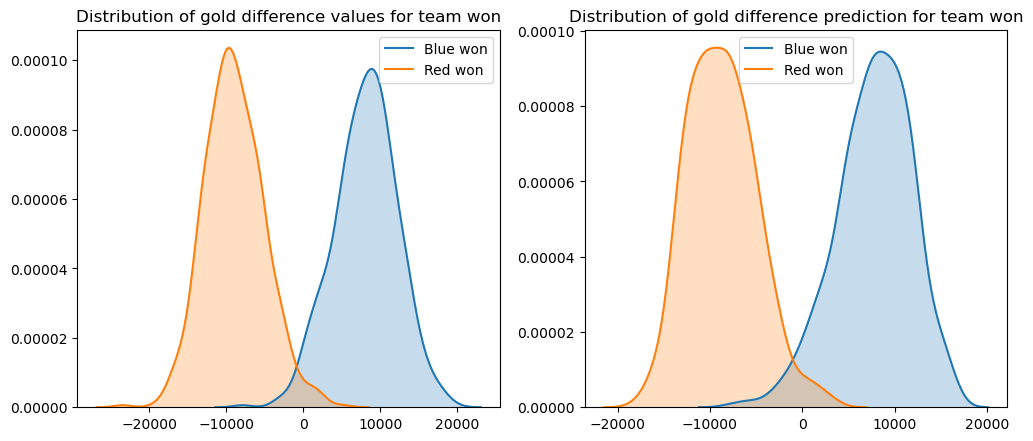

In [18]:
# Plotting gold spread by team won (real vs predicted)
# Real
plt_target_data = pd.concat([y_diff_gold_test, y_test], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(plt_target_data.loc[plt_target_data['Blue_Won']==1]['Diff_Gold'], shade=True, ax=ax[0])
sns.kdeplot(plt_target_data.loc[plt_target_data['Blue_Won']==0]['Diff_Gold'], shade=True, ax=ax[0])

ax[0].legend(['Blue won', 'Red won'])
ax[0].set_title('Distribution of gold difference values for team won')

# Predicted
plt_pred_data =  pd.concat([pd.Series(preds, index=y_test.index), y_test], axis=1)

sns.kdeplot(plt_pred_data.loc[plt_pred_data['Blue_Won']==1][0], shade=True, ax=ax[1])
sns.kdeplot(plt_pred_data.loc[plt_pred_data['Blue_Won']==0][0], shade=True, ax=ax[1])

ax[1].legend(['Blue won', 'Red won'])
ax[1].set_title('Distribution of gold difference prediction for team won');

#!!!Add something about non-normal target value after you've talked with JQ about it.
&emsp; Since Gold_Diff is the most useful feature (and the feature that contains the most information since a lot of other features influence it), it is wise to properly examine it. I took into acount simple Lin.Reg. and XGB Regressor, but since the vanilla XGB was there only for comparison and since it is not as __interpretable__, I decided to stick with the __Lin.Reg.__ for the most time.<br>
&emsp; __RMSE__ of 2300 gold is actually an excellent number since that means that error difference beteween each player is only 460, which is practically nothing, __1st and 3rd quartiles__ of ~7500 are also pretty good.<br>
&emsp;It seems that __between-the-features correlation__ is messing the things up again (will be adressed shortly), as observed before, some Lin.Reg. coefficients have completely opposite values. On the other side, the __proportion of coefficients__ seems okay at glance (except __Diff_KillsInhib__).

### Feature reduction by components - PCA/PLS

In [30]:
from sklearn.decomposition import PCA

diff_data_scaled = scaler.fit_transform(diff_data)

pca = PCA(n_components=4)
pca.fit(diff_data_scaled)

print('Explained variance ratio by the first 4 components:', sum(pca.explained_variance_ratio_).round(6))

pca_data = pca.transform(diff_data_scaled)

pca_lr = LogisticRegression()
pca_lr.fit(pca_data, y_train)

pca_test = pca.transform(scaler.transform(diff_test))

print('Test set accuracy:', round(accuracy_score(y_test, pca_lr.predict(pca_test)), 5))

Explained variance ratio by the first 4 components: 0.961634
Test set accuracy: 0.97625


In [31]:
pd.DataFrame(confusion_matrix(y_test, pca_lr.predict(pca_test)), index=['Real Blue Lost', 'Real Blue Won'],
             columns=['Pred Blue Lost', 'Pred Blue Won'])

,Pred Blue Lost,Pred Blue Won
Real Blue Lost,564,12
Real Blue Won,15,546


&emsp;Scikit-learn inverts the confusion matrix by default (inverted binary classes).

In [41]:
# Exporting pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('lr', LogisticRegression())])
pipeline.fit(diff_data, y_train)

with open('lr_pipeline.pkl', 'wb') as f:
    joblib.dump(pipeline, f)
    
joblib.dump(pipeline, 'lr_pipeline.pkl')

['lr_pipeline.pkl']

### Neural Net to combine the time feature with other features (late game feature importance)
Why you wanna do this:
 - As the game progresses, the gold diff becomes less significant
 - Some champions are good late game
 - Actually most of the features become more or less useless later on (you could evaluate "team skill" early    on to see the outcome later - better team weight - talk to JQ

In [ ]:
# Game Duration and ChapionID correlation by the Blue Won games
corrs = {}

for champ in data['Blue_Top_ChampionID'].unique():
    curr_data = data.loc[data['Blue_Won']==1]
    curr_data['Blue_Top_ChampionID'] = np.where(curr_data['Blue_Top_ChampionID']==champ, 1, 0)
    
    corrs[champ] = curr_data['GameDuration'].corr(curr_data['Blue_Top_ChampionID']).round(3)
    
corrs = {k: v for k, v in sorted(corrs.items(), key=lambda item: item[1])}

# Game Duration and ChapionID correlation by the Blue Won and Duration>35min games
corrs = {}

for champ in data['Blue_Top_ChampionID'].unique():
    curr_data = data.loc[(data['GameDuration']>2100)&(data['Blue_Won']==1)]
    curr_data['Blue_Top_ChampionID'] = np.where(curr_data['Blue_Top_ChampionID']==champ, 1, 0)
    
    corrs[champ] = curr_data['GameDuration'].corr(curr_data['Blue_Top_ChampionID']).round(3)

corrs = {k: v for k, v in sorted(corrs.items(), key=lambda item: item[1])}